In [1]:
from __future__ import division

from pylab import *
import random_idx
import scipy
import time

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42



height has been deprecated.

2016-10-10 13:05


In [2]:
import scipy
def ncdf(z):
    return 0.5 * (1 + scipy.special.erf(z/2**0.5))

def p_correct_decay(M,ll=1, N=10000, D=27, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))
    
    dM = (1 / (1 - ll**2))
    
    for iM,Mval in enumerate(M):
        avals = np.linspace(N * ll ** Mval - 8 * (N*dM)**0.5, N * ll ** Mval + 8 * (N*dM)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N * ll ** Mval) / ((dM)*N)**0.5) - ncdf((avals[:-1]-N * ll ** Mval) / ((dM)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(dM*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

In [3]:
def clip_decay2(lb, clip=5):
    '''
    Approximates the decay in the hit dot product when there is clipping. 
    '''
    
    # This is going to keep track of how many elements are a value between -clip and + clip
    # We assume that the hypervector is "filled" before a memory item is added. This means
    # that there is a uniform distribution across the values of each element.
    vec = np.ones(2*clip+1)
    
    # When we add a vector to remember, this distribution shifts. The clipping then
    # causes there to be one less element with value -clip, and one extra element
    # with value clip.
    vec[0] -= 1
    vec[-1] += 1
    
    decay = np.zeros(lb)
    cvar = np.zeros(lb)
    
    for l in range(lb):
        # the sum of vec divided by the number of states is the amount the dot product 
        # is reduced.
        decay[l] = np.sum(vec * arange(-clip, clip+1)) / ((2*clip+1))
        cvar[l] = np.sum(vec * arange(-clip, clip+1) ** 2) / ((2*clip+1))
        vect = vec.copy()
        
        # As we add more vectors/look back further in the history the distribution of the
        # elements changes. Slowly the distribution returns to uniform.
        vec[1:-1] = (vect[:-2] + vect[2:]) / 2        
        vec[0] = (vect[0] + vect[1]) / 2
        vec[-1] = (vect[-1] + vect[-2]) / 2

    return decay, cvar

        

In [4]:
def tanh_decay(lb, k=10, init_vec=None, vecres=100, show_plot=False, noshift=False):
    
    # @todo: vecres needs to be odd
    
    if init_vec is None:
        vecres = 2*(vecres * k // 2) + 1 # make sure its odd
        vec = np.zeros(vecres)
        vec[vecres//2] = 1
        #vec[:] = 1.0/vecres
        init_vec = vec.copy()
        
    else:
        vec = init_vec
        vecres = len(vec)
    
    xbins = linspace(0, 1, vecres)
    thxb = np.tanh(xbins + 1.0/k)

    xk = xbins[np.nonzero(thxb < xbins)[0][0]]
    
    
    vecbins = linspace(-xk - 1.0/k, xk + 1.0/k, len(vec)) 
    
    vecshiftp = np.tanh(vecbins + 1.0/k)
    vecshiftn = np.tanh(vecbins - 1.0/k)
    vecshiftpi = np.zeros_like(vecshiftp)
    vecshiftni = np.zeros_like(vecshiftp)
    for i in range(vecbins.shape[0]):
        vecshiftpi[i] = np.abs(vecbins-vecshiftp[i]).argmin()
        vecshiftni[i] = np.abs(vecbins-vecshiftn[i]).argmin()

    if not noshift:
        # shift the vec 1
        vecp = np.zeros_like(vec)
        for i in range(vecbins.shape[0]):        
            vecp[vecshiftpi[i]] += vec[i]
        vec = vecp
    
    decay = np.zeros(lb)
    dvar = np.zeros(lb)
         
    cm = get_cmap('Blues_r', lb+30)

    for l in range(lb):
        if show_plot:
            if l == 0 or l == (lb-1):
                plot(k * vecbins, vec, c=cm(l), lw=2, label='Lookback: %i' % (l+1))
            else:
                plot(k * vecbins, vec, c=cm(l), lw=2)
        
        decay[l] = np.sum(vecbins * vec * k)
        dvar[l] = np.sum((k * vecbins-decay[l])**2 * vec)
        vecn = np.zeros_like(vec)
        vecp = np.zeros_like(vec)

        for i in range(vecbins.shape[0]):
            vecn[vecshiftni[i]] += vec[i]
            vecp[vecshiftpi[i]] += vec[i]
        
        vec = 0.5 * vecn + 0.5 * vecp
        #vec /= sum(vec)
     
    
    #if show_plot:
    #    plot(vecbins, init_vec, 'r', lw=2)
    
    return decay, dvar, vec

       

In [10]:
def tanh_filled(clip, vv=100):
    
    vecres = vv * clip
    xbins = linspace(0, 1, vecres)
    thxb = np.tanh(xbins + 1.0/clip)
    xk = xbins[np.nonzero(thxb < xbins)[0][0]]

    init_vec = np.zeros(vecres)

    vecbins = linspace(-xk - 1.0/clip, xk + 1.0/clip, len(init_vec)) 

    vec_idx = np.logical_and(vecbins > -xk, vecbins < xk)

    init_vec[vec_idx] = 1 / len(vec_idx)
    
    cdecay, cvar, final_vec = tanh_decay(2*clip, k=clip, init_vec=init_vec, noshift=True)
    
    return final_vec

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:57: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


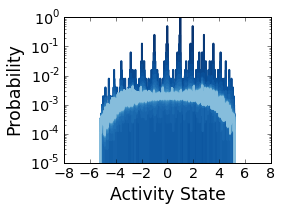

In [83]:
figure(figsize=(4,3))
            
clip=8
lookback = 40
decay, dvar, fv2 = tanh_decay(lookback, k=clip, show_plot=True)

#decay, dvar, final_vec = tanh_decay(lookback, k=clip)
#title('Distribution of elements, tanh')
ylabel('Probability')
xlabel('Activity State')
yscale('log')   
ylim([1e-5, 1e0])
xlim([-clip, clip])
#legend(loc='low left')
plt.tight_layout()

savefig('figures/capacity-tanh-distribution-y-xscale-clip=' + str(clip) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity-tanh-distribution-y-xscale-clip=' + str(clip) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:57: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


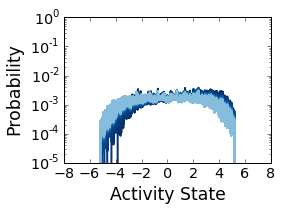

In [84]:
clip=8
lookback = 40
final_vec = tanh_filled(clip)
figure(figsize=(4,3))

decay, dvar, fv2 = tanh_decay(lookback, k=clip, init_vec=final_vec, show_plot=True)

#title('Distribution of elements, tanh')
ylabel('Probability')
xlabel('Activity State')
yscale('log')   
ylim([1e-5, 1e0])
xlim([-1*clip, 1*clip])
plt.tight_layout()

#legend(loc='low left')

savefig('figures/capacity-tanh-filled-y-distribution-clip=' + str(clip) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity-tanh-filled-y-distribution-clip=' + str(clip) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

In [671]:
k=20
xbins = linspace(0, 1, vecres)
thxb = np.tanh(xbins + 1.0/k)

np.nonzero(thxb < xbins)


(array([2511, 2512, 2513, ..., 4998, 4999, 5000]),)

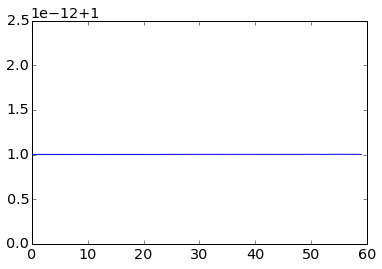

In [677]:
plot(decay)

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:57: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


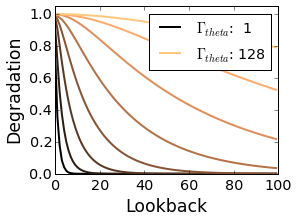

In [19]:
figure(figsize=(4,3))
test_clip = [2**k for k in range(8)]

cm = get_cmap('copper', len(test_clip))
for ic,clip in enumerate(test_clip):
    cdecay, cvar, fv = tanh_decay(100, k=clip)
    if ic >= 1 and ic < len(test_clip) - 1:
        plot(cdecay, color=cm(ic), lw=2)
    else:
        plot(cdecay, color=cm(ic), label='$\Gamma_{theta}$: %2i'%clip, lw=2)
    
ylim([0, 1.05])
legend()
ylabel('Degradation')
xlabel('Lookback')
#title('Dot Product Degredation')
plt.tight_layout()

savefig('figures/capacity-tanh-degredation' + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity-tanh-degredation' + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

0 1

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:57: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


 2 3 4 5 6 7


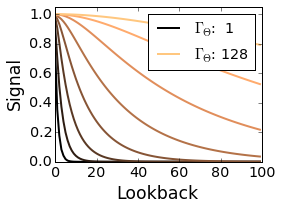

In [85]:
figure(figsize=(4,3))
#test_clip = arange(5)+30
#test_clip =  2*arange(5)**2 + 1
test_clip = [2**k for k in range(8)]

cm = get_cmap('copper', len(test_clip))
for ic,clip in enumerate(test_clip):
    print ic,
    
    cdecay, cvar, fv = tanh_decay(100, k=clip)
    if ic >= 1 and ic < len(test_clip) - 1:
        plot(cdecay, color=cm(ic), lw=2)
    else:
        plot(cdecay, color=cm(ic), label='$\Gamma_{\Theta}$: %2i'%clip, lw=2)
    
legend()
ylabel('Signal')
xlabel('Lookback')
#title('Dot Product Degredation')
ylim([0,1.05])
plt.tight_layout()

savefig('figures/capacity-tanh-degredation' + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity-tanh-degredation' + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

In [688]:
clip

800

0 1

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:57: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


 2 3 4 5 6 7


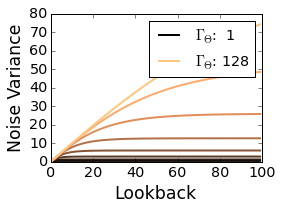

In [86]:
figure(figsize=(4,3))
#test_clip = 2*arange(10)**2+1

cm = get_cmap('copper', len(test_clip))
for ic,clip in enumerate(test_clip):
    print ic,
    cdecay, cvar,fv = tanh_decay(100, k=clip)
    if ic >= 1 and ic < len(test_clip) - 1:
        plot(cvar, color=cm(ic), lw=2)
    else:
        plot(cvar, color=cm(ic), label='$\Gamma_{\Theta}$: %2i'%clip, lw=2)
    
legend()
ylabel('Noise Variance')
xlabel('Lookback')
#title('Dot Product Noise')
plt.tight_layout()

savefig('figures/capacity-tanh-variance' + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity-tanh-variance' + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:55: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:56: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


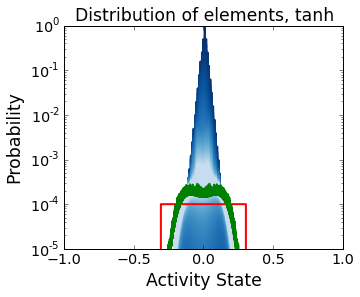

In [715]:

clip=100
lookback = 160
figure(figsize=(5,4))
decay, dvar, final_vec = tanh_decay(lookback, k=clip, show_plot=True)
title('Distribution of elements, tanh')
ylabel('Probability')
xlabel('Activity State')
yscale('log')   
ylim([1e-5, 1e0])
xlim([-1, 1])


xbins = linspace(0, 1, vecres)
thxb = np.tanh(xbins + 1.0/clip)
xk = xbins[np.nonzero(thxb < xbins)[0][0]]

init_vec = np.zeros(100 * clip)

vecbins = linspace(-xk - 1.0/k, xk + 1.0/k, len(init_vec)) 

vec_idx = np.logical_and(vecbins > -xk, vecbins < xk)

init_vec[vec_idx] = 1 / len(vec_idx)

plot(vecbins, init_vec, 'r', lw=2)

cdecay, cvar, final_vec = tanh_decay(clip, k=clip, init_vec=init_vec, noshift=True)

plot(vecbins, final_vec, 'g', lw=2)

0 1

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:57: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


 2 3 4 5 6 7


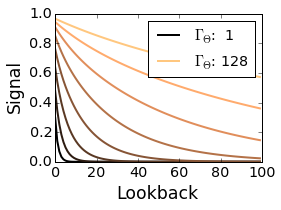

In [87]:
#test_clip = 2*arange(10)**2+1

figure(figsize=(4,3))
test_clip = [2**k for k in range(8)]

cm = get_cmap('copper', len(test_clip))
for ic,clip in enumerate(test_clip):
    print ic,
    
    final_vec = tanh_filled(clip)
    cdecay, cvar, fv = tanh_decay(100, k=clip, init_vec=final_vec)
    if ic >= 1 and ic < len(test_clip) - 1:
        plot(cdecay, color=cm(ic), lw=2)
    else:
        plot(cdecay, color=cm(ic), label="$\Gamma_{\Theta}$: %2i" % clip, lw=2)
    
legend()
ylabel('Signal')
xlabel('Lookback')
#title('Dot Product Degredation')
ylim([0,1])
plt.tight_layout()

savefig('figures/capacity-tanh-filled-degredation' + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity-tanh-filled-degredation' + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

0 1

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:57: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


 2 3 4 5 6 7


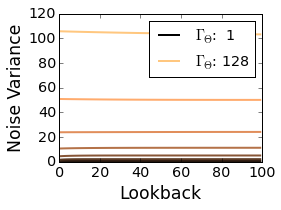

In [88]:
#test_clip = arange(20)+1

figure(figsize=(4,3))

cm = get_cmap('copper', len(test_clip))
for ic,clip in enumerate(test_clip):
    print ic,
    #cdecay, cvar, final_vec = tanh_decay(2*clip, k=clip)
    final_vec = tanh_filled(clip)

    cdecay, cvar, final_vec = tanh_decay(100, k=clip, init_vec=final_vec)
    if ic >= 1 and ic < len(test_clip) - 1:
        plot(cvar, color=cm(ic), lw=2)
    else:
        plot(cvar, color=cm(ic), label="$\Gamma_{\Theta}$: %2i" % clip, lw=2)
    
legend()
ylabel('Noise Variance')
xlabel('Lookback')
#title('Dot Product Noise')
plt.tight_layout()

savefig('figures/capacity-tanh-filled-variance' + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity-tanh-filled-variance' + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

In [25]:
def p_correct_clip(M,clip=5, N=10000, D=len(random_idx.alphabet), ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))
    
    dM = ((2.0*clip+1) ** 2.0 -1.0) / 12.0
    
    decay, cvar = clip_decay2(max(M)+1, clip=clip)
    #vdecay = clip_decay_var(max(M)+1, clip=clip)
    
    for iM,Mval in enumerate(M):
        
        val = decay[Mval] * N
        #vval = vdecay[Mval] * N
        vval = dM * N
        
        avals = np.linspace(val - 8 * (vval)**0.5, val+ 8 * (vval)**0.5, ares)
        
        
        p[:, iM] = ncdf((avals[1:] - val) / (vval**0.5)) - ncdf((avals[:-1] - val) / (vval**0.5))
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(dM*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

In [26]:
def p_correct_tanh(M,k=5, N=10000, D=len(random_idx.alphabet), ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))
        
    final_vec = tanh_filled(clip)
    decay, cvar, fv = tanh_decay(max(M)+1, k=k, init_vec=final_vec)
    
    #vdecay = clip_decay_var(max(M)+1, clip=clip)
    
    for iM,Mval in enumerate(M):
        
        val = decay[Mval] * N
        vval = cvar[Mval] * N
        
        avals = np.linspace(val - 8 * (vval)**0.5, val+ 8 * (vval)**0.5, ares)
        
        
        p[:, iM] = ncdf((avals[1:] - val) / (vval**0.5)) - ncdf((avals[:-1] - val) / (vval**0.5))
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(vval**0.5))) ** (D-1)

    return np.sum(p, axis=0)

In [27]:
def p_correct_tanh0(M,k=5, N=10000, D=len(random_idx.alphabet), ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))
        
    decay, cvar, fv = tanh_decay(max(M)+1, k=k)
    
    #vdecay = clip_decay_var(max(M)+1, clip=clip)
    
    for iM,Mval in enumerate(M):
        
        val = decay[Mval] * N
        vval = cvar[Mval] * N
        
        avals = np.linspace(val - 8 * (vval)**0.5, val+ 8 * (vval)**0.5, ares)
        
        
        p[:, iM] = ncdf((avals[1:] - val) / (vval**0.5)) - ncdf((avals[:-1] - val) / (vval**0.5))
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(vval**0.5))) ** (D-1)

    return np.sum(p, axis=0)

## Saturating non-linearities

This should be very similar to clipping.


In [28]:
def test_capacity_tanh_lookback(N, D, rescale=10, trials=None):
    letter_vectors = 2 * (np.random.randn(D, N) > 0) - 1
    
    letter_vectors = 1.0/rescale * letter_vectors
    
    hypercapacity = np.zeros(N)

    if trials is None:
        trials = N
        
    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    hypercapacity = letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)
    

    for i in range(int(trials)-1):
        
        lidx[i+1] = np.random.randint(D)

        hypercapacity = np.tanh(np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :])
        
        v_last_input = np.roll(hypercapacity, -1)
        #v_input_K = np.roll(hypercapacity, -K) # we can still do this less than K, it will just be noise
        v_first_input = np.roll(hypercapacity, -(i+1))
        
        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        #lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))
        
    # instead of keeping a single K, going to look back with increasing K at the end
    for i in range(int(trials)):
        v_input_K = np.roll(hypercapacity, -(int(trials)-i-1))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input, hypercapacity

In [29]:
def test_capacity_tanh(N, D, K=1, rescale=10, trials=None):
    letter_vectors = 2 * (np.random.randn(D, N) > 0) - 1
    
    ## double check
    #letter_vectors = 1.0/rescale * letter_vectors
    
    hypercapacity = np.zeros(N)

    if trials is None:
        trials = N
        
    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    hypercapacity = letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)
    

    for i in range(int(trials)-1):
        
        lidx[i+1] = np.random.randint(D)

        ## double check
        #hypercapacity = np.tanh(np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :])
        hypercapacity = rescale * np.tanh((np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :])/rescale)
        
        v_last_input = np.roll(hypercapacity, -1)
        v_input_K = np.roll(hypercapacity, -K) # we can still do this less than K, it will just be noise
        v_first_input = np.roll(hypercapacity, -(i+1))
        
        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))
        
    # instead of keeping a single K, going to look back with increasing K at the end
    #for i in range(int(trials)):
    #    v_input_K = np.roll(hypercapacity, -(int(trials)-i-1))
    #    lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input, hypercapacity

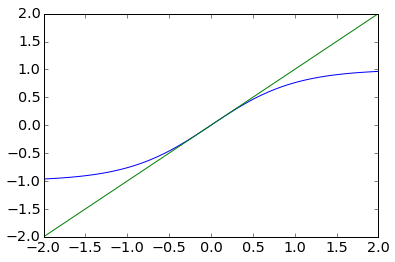

In [274]:
x = linspace(-2, 2, 100)

plot(x, tanh(x))
plot(x,x)

In [275]:
lix, li, ik, fi, hyp = test_capacity_tanh_lookback(N, len(random_idx.alphabet), rescale=3)

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-pac

Duration:  22.561095953


(array([ 520.,  422.,  545.,  510.,  542.,  497.,  496.,  530.,  454.,  484.]),
 array([ -8.18254819e-01,  -6.54601190e-01,  -4.90947561e-01,
         -3.27293933e-01,  -1.63640304e-01,   1.33244785e-05,
          1.63666953e-01,   3.27320582e-01,   4.90974210e-01,
          6.54627839e-01,   8.18281468e-01]),
 <a list of 10 Patch objects>)

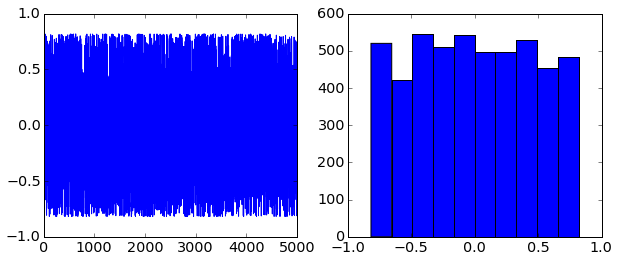

In [276]:
figure(figsize=(10,4))

subplot(121)
plot(hyp)

subplot(122)
hist(hyp)

In [58]:
N =5000
M = arange(N)+1
test_clip = [4, 16,  64,  256, 1024]
#test_clip = arange(8) + 1
#test_clip = arange(8) + 1

runs = 15

run_id = []
run_clip = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

clip_mean_all = []
clip_var_all = []

pc_all = []

lv = 2*(np.random.randn < 0) -1 

for r in range(runs):
    print r
    for clip in test_clip:
        lidx, lidx_li, lidx_iK, lidx_fi, hypvec = test_capacity_tanh_lookback(N, len(random_idx.alphabet), rescale=clip)
        

        run_id.append(r)
        run_clip.append(clip)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
        clip_mean_all.append(np.dot(lv,hypvec))
        clip_var_all.append(var(hypvec))

        
for clip in test_clip:
    tst = time.time()
    pc_tanh = p_correct_tanh(M, N=N, k=clip)
    pc_all.append(pc_tanh)
    print 'Elapsed: ', time.time()-tst


filename = 'data/capacity-tanh-lookback-N=' + str(N) + '-tc=' + str(len(test_clip)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all,
        run_id=run_id, run_clip=run_clip, runs=runs, N=N, D=len(random_idx.alphabet), test_clip=test_clip,
        clip_mean_all=clip_mean_all, clip_var_all=clip_var_all, pc_all=pc_all)

0


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Duration:  1.59804487228
Duration:  1.48589897156
Duration:  1.40172386169
Duration:  1.33862304688
Duration:  1.34716582298
1
Duration:  1.5718319416
Duration:  1.51661396027
Duration:  1.42869877815
Duration:  1.33851218224
Duration:  1.34577512741
2
Duration:  1.61012911797
Duration:  1.49075508118
Duration:  1.38593292236
Duration:  1.33633780479
Duration:  1.3781709671
3
Duration:  1.63891100883
Duration:  1.50245904922
Duration:  1.38545393944
Duration:  1.47456216812
Duration:  1.35234904289
4
Duration:  1.60110402107
Duration:  1.49714994431
Duration:  1.50833392143
Duration:  1.33942198753
Duration:  1.33149504662
5
Duration:  1.59267807007
Duration:  1.50961589813
Duration:  1.38152694702
Duration:  1.33916282654
Duration:  1.34320998192
6
Duration:  1.58930492401
Duration:  1.49868512154
Duration:  1.37897777557
Duration:  1.337900877
Duration:  1.34817695618
7
Duration:  1.59609389305
Duration:  1.47475504875
Duration:  1.3861079216
Duration:  1.36642980576
Duration:  1.376

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:57: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Elapsed:  14.7751221657
Elapsed:  52.3178999424
Elapsed:  203.570542097
Elapsed:  885.698065996
Elapsed:  4524.61613011
data/capacity-tanh-lookback-N=5000-tc=5-r=15-n161010.npz


In [89]:
#h = np.load('data/hypervector_capacity_decay-d=0.998-N=1-D=3-r=5-n160518.npz')
#h = np.load('data/capacity-tanh-lookback-N=2000-tc=5-r=5-n160623.npz')
#h = np.load('data/capacity-tanh-lookback-N=5000-tc=12-r=5-n160623.npz')
#h = np.load('data/capacity-tanh-lookback-N=5000-tc=10-r=5-n160728.npz')
#h = np.load('data/capacity-tanh-N=10000-tc=5-r=5-n160728.npz')
#h = np.load('data/capacity-tanh0-N=2000-tc=4-r=5-n160803.npz')
#h = np.load('data/capacity-tanh-lookback-N=2000-tc=4-r=5-n160803.npz')
#h = np.load('data/capacity-tanh0-N=2000-tc=4-r=5-n160803.npz')
#h = np.load('data/capacity-tanh-lookback-N=5000-tc=2-r=5-n161010.npz')
h = np.load('data/capacity-tanh-lookback-N=5000-tc=5-r=15-n161010.npz')

lidx_all=h['lidx_all']
lidx_li_all=h['lidx_li_all']
lidx_iK_all=h['lidx_iK_all']
lidx_fi_all=h['lidx_fi_all']
run_id=h['run_id']
run_clip=h['run_clip']
runs=h['runs']
N=h['N']
D=h['D']
test_clip=h['test_clip']
clip_mean_all=h['clip_mean_all']
clip_var_all=h['clip_var_all']
pc_all = h['pc_all']

In [90]:
run_id = np.array(run_id)
run_clip = np.array(run_clip)

uclip = unique(run_clip)

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uclip)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uclip)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uclip)))

for idx_clip, clip in enumerate(uclip):
    idxs = find(run_clip==clip)
    for i in idxs:
        li_mean[:,idx_clip] += np.array(lidx_all[i] == lidx_li_all[i])
        iK_mean[:,idx_clip] += np.array(lidx_all[i] == np.roll(lidx_iK_all[i], -K+1))  
        fi_mean[:,idx_clip] += np.array(lidx_all[i][0] == lidx_fi_all[i])
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


0.00398707389832
0.00783610343933
0.0113899707794
0.0151000022888
0.0187079906464


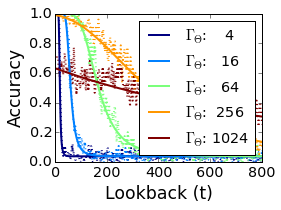

In [91]:
figure(figsize=(4,3))

cm=get_cmap('jet', iK_mean.shape[1])
smoothN=5
for i in range(iK_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    plot(arange(iK_mean.shape[0], 0, -1)[:-5],
         np.convolve(iK_mean[:,i], np.ones(smoothN)/smoothN, mode='same')[:-5],
         ':', color=cm(i), lw=2)
    
    #pcd = p_correct_decay(arange(iK_mean.shape[0])+1, ll=decay, N=N, D=test_D[i]) 
    #plot(arange(iK_mean.shape[0]), pcd, lw=3, color=cm(i))

M = arange(pc_all[0].shape[0])+1
cm = get_cmap('jet', len(test_clip))
tstart= time.time()
#for il,ll in enumerate(test_ll):
for il, clip in enumerate(test_clip):
    #ll = 1 - tanh(1)**2/clip #np.sqrt(1 - (12.0 / ((2*clip+1)**2 - 1)))
    #plot(M, p_correct_decay(M, N=N, ll=ll), '--', color=cm(il), lw=2)
    #plot(M, p_correct_clip(M, N=N, clip=round((2*clip)**0.5)), color=cm(il), lw=2)
    plot(M, pc_all[il], c=cm(il), lw=2, label="$\Gamma_{\Theta}$: %4i" % clip)
    print time.time() - tstart

legend(loc='upper right')
#title(r'Readout from end');
xlabel('Lookback (t)');
ylabel('Accuracy')
ax = gca()
ax.set_xticks(arange(0, 802, 200))
xlim([0, 800])
plt.tight_layout()

#xscale('log')
#yscale('log')

#savefig('figures/capacity-clipping-lookback-eig_approx' + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
#savefig('figures/capacity-clipping-lookback-eig_approx' + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)
savefig('figures/capacity-tanh-lookback-N=' + str(N) + '-tc=' + str(len(test_clip)) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity-tanh-lookback-N=' + str(N) + '-tc=' + str(len(test_clip)) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

In [62]:
N =5000
M = arange(N)+1
test_clip = [4, 16,  64,  256, 1024]
#test_clip = arange(8) + 1
#test_clip = arange(8) + 1

runs = 15

run_id = []
run_clip = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

clip_mean_all = []
clip_var_all = []

pc_all = []

lv = 2*(np.random.randn < 0) -1 

for r in range(runs):
    print r
    for clip in test_clip:
        lidx, lidx_li, lidx_iK, lidx_fi, hypvec = test_capacity_tanh(N, len(random_idx.alphabet), rescale=clip)
        run_id.append(r)
        run_clip.append(clip)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
        clip_mean_all.append(np.dot(lv,hypvec))
        clip_var_all.append(var(hypvec))
        
    
for clip in test_clip:
            
    tst = time.time()
    
    pc_tanh = p_correct_tanh0(M, N=N, k=clip)
    pc_all.append(pc_tanh)
    
    print 'Elapsed: ', time.time()-tst

    
filename = 'data/capacity-tanh0-N=' + str(N) + '-tc=' + str(len(test_clip)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all,
        run_id=run_id, run_clip=run_clip, runs=runs, N=N, D=len(random_idx.alphabet), test_clip=test_clip,
        clip_mean_all=clip_mean_all, clip_var_all=clip_var_all, pc_all=pc_all)

0


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Duration:  4.96416497231
Duration:  4.37226200104
Duration:  4.1099190712
Duration:  4.38425779343
Duration:  4.0635778904
1
Duration:  4.79792690277
Duration:  4.54635000229
Duration:  4.19999098778
Duration:  4.38900184631
Duration:  4.17975783348
2
Duration:  4.45757889748
Duration:  4.51489710808
Duration:  4.06057500839
Duration:  4.44051098824
Duration:  4.22743606567
3
Duration:  4.41413903236
Duration:  4.26078605652
Duration:  4.73438382149
Duration:  4.33373713493
Duration:  3.98577404022
4
Duration:  4.48466491699
Duration:  4.24379086494
Duration:  4.15070605278
Duration:  4.00683093071
Duration:  3.92313098907
5
Duration:  4.40981411934
Duration:  4.29683899879
Duration:  4.17067408562
Duration:  4.21334600449
Duration:  4.26351308823
6
Duration:  4.42179298401
Duration:  4.40252685547
Duration:  4.44096398354
Duration:  4.16938996315
Duration:  4.29030799866
7
Duration:  4.23501682281
Duration:  4.34258508682
Duration:  4.08536815643
Duration:  3.96657109261
Duration:  4.

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:57: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Elapsed:  14.7011399269
Elapsed:  49.7636020184
Elapsed:  195.171344042
Elapsed:  764.537261009
Elapsed:  3202.96792579
data/capacity-tanh0-N=5000-tc=5-r=15-n161010.npz


In [92]:
#h = np.load('data/hypervector_capacity_decay-d=0.998-N=1-D=3-r=5-n160518.npz')
#h = np.load('data/capacity-tanh-lookback-N=2000-tc=5-r=5-n160623.npz')
#h = np.load('data/capacity-tanh-lookback-N=5000-tc=12-r=5-n160623.npz')
#h = np.load('data/capacity-tanh-lookback-N=5000-tc=10-r=5-n160728.npz')
#h = np.load('data/capacity-tanh-N=10000-tc=5-r=5-n160728.npz')
#h = np.load('data/capacity-tanh0-N=2000-tc=4-r=5-n160803.npz')
#h = np.load('data/capacity-tanh-lookback-N=2000-tc=4-r=5-n160803.npz')
#h = np.load('data/capacity-tanh0-N=2000-tc=4-r=5-n160803.npz')
#h = np.load('data/capacity-tanh-lookback-N=5000-tc=5-r=15-n160803.npz')
#h = np.load('data/capacity-tanh0-N=5000-tc=2-r=5-n161010.npz')
h = np.load('data/capacity-tanh0-N=5000-tc=5-r=15-n161010.npz')

lidx_all=h['lidx_all']
lidx_li_all=h['lidx_li_all']
lidx_iK_all=h['lidx_iK_all']
lidx_fi_all=h['lidx_fi_all']
run_id=h['run_id']
run_clip=h['run_clip']
runs=h['runs']
N=h['N']
D=h['D']
test_clip=h['test_clip']
clip_mean_all=h['clip_mean_all']
clip_var_all=h['clip_var_all']
pc_all = h['pc_all']

In [93]:
run_id = np.array(run_id)
run_clip = np.array(run_clip)

uclip = unique(run_clip)

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uclip)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uclip)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uclip)))

for idx_clip, clip in enumerate(uclip):
    idxs = find(run_clip==clip)
    for i in idxs:
        li_mean[:,idx_clip] += np.array(lidx_all[i] == lidx_li_all[i])
        iK_mean[:,idx_clip] += np.array(lidx_all[i] == np.roll(lidx_iK_all[i], -K+1))  
        fi_mean[:,idx_clip] += np.array(lidx_all[i][0] == lidx_fi_all[i])
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


0.00395393371582
0.00779294967651
0.0115549564362
0.015172958374
0.0187981128693


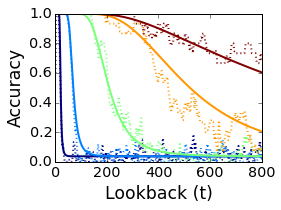

In [94]:
figure(figsize=(4,3))

cm=get_cmap('jet', fi_mean.shape[1])
smoothN=5
for i in range(fi_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    plot(arange(fi_mean.shape[0])[:-5],
         np.convolve(fi_mean[:,i], np.ones(smoothN)/smoothN, mode='same')[:-5],
         ':', color=cm(i), lw=2)
    
    #pcd = p_correct_decay(arange(iK_mean.shape[0])+1, ll=decay, N=N, D=test_D[i]) 
    #plot(arange(iK_mean.shape[0]), pcd, lw=3, color=cm(i))

M = arange(pc_all[0].shape[0])+1
cm = get_cmap('jet', len(test_clip))

tstart = time.time()
#for il,ll in enumerate(test_ll):
for il, clip in enumerate(test_clip):
    #ll = 1 - tanh(1)**2/clip #np.sqrt(1 - (12.0 / ((2*clip+1)**2 - 1)))
    #plot(M, p_correct_decay(M, N=N, ll=ll), '--', color=cm(il), lw=2)
    #plot(M, p_correct_clip(M, N=N, clip=round((2*clip)**0.5)), color=cm(il), lw=2)
    plot(M, pc_all[il], c=cm(il), lw=2, label="$\Gamma_{\Theta}$: %4i" % clip)
    print time.time() - tstart
    
#legend(loc='upper right')
#title(r'Readout from end', fontsize=20);
xlabel('Lookback (t)');
ylabel('Accuracy')
ax = gca()
ax.set_xticks(arange(0, 802, 200))
xlim([0, 800])
plt.tight_layout()#legend(loc='upper right')

#xscale('log')
#yscale('log')

#savefig('figures/capacity-clipping-lookback-eig_approx' + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
#savefig('figures/capacity-clipping-lookback-eig_approx' + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)
savefig('figures/capacity-tanh0-N=' + str(N) + '-tc=' + str(len(test_clip)) + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity-tanh0-N=' + str(N) + '-tc=' + str(len(test_clip)) + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

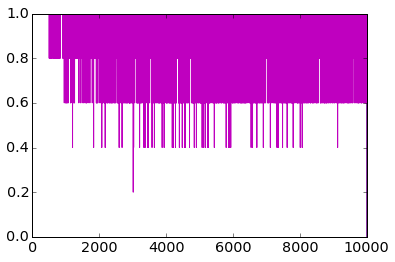

In [380]:
plot(li_mean)

In [255]:
N

array(5000)

In [114]:
tanh(1/3)


0.32151273753163434

In [112]:
tanh(1)**2/3

0.19334188612865796

In [ ]:
lix, li, ik, fi, hyp = test_capacity_tanh_lookback(N, len(random_idx.alphabet), rescale=3)

(array([  40.,  278.,  618.,  834.,  859.,  900.,  835.,  528.,  103.,    5.]),
 array([-0.05213925, -0.04103697, -0.02993469, -0.01883241, -0.00773013,
         0.00337215,  0.01447443,  0.02557671,  0.03667899,  0.04778127,
         0.05888356]),
 <a list of 10 Patch objects>)

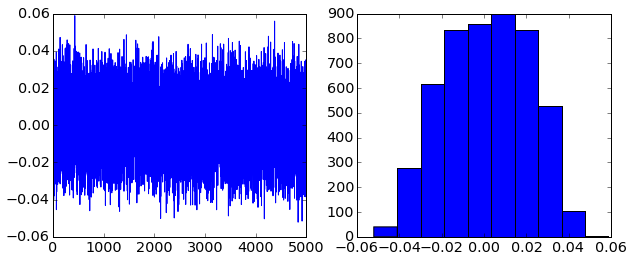

In [70]:
figure(figsize=(10,4))

subplot(121)
plot(hyp)

subplot(122)
hist(hyp)

1.82094906422e-06
1.82093402566e-06


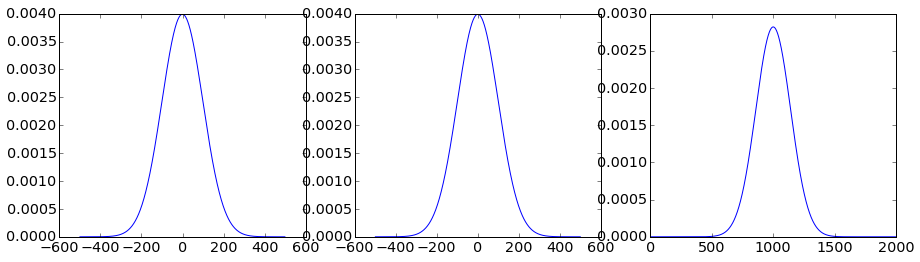

In [58]:
from scipy.signal import gaussian

winsize=1000
gaussvar = 10000

clip = 1
winx = arange(winsize) - winsize//2

gausswin = gaussian(winsize, gaussvar**0.5)/np.sqrt(2*pi*gaussvar)
tanhwin = np.tanh(gausswin/clip)

conv_dist = np.convolve(tanhwin, gausswin)

figure(figsize=(15,4))
subplot(131)
plot(winx, gausswin)
subplot(132)
plot(winx, tanhwin)
subplot(133)
plot(conv_dist)

print var(gausswin/clip)
print var(tanhwin)

In [39]:
sum(gausswin)

0.99999942675879883

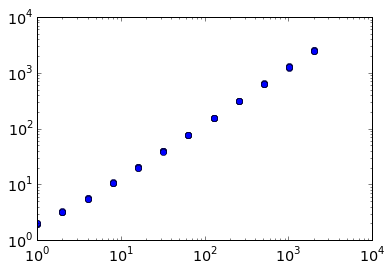

In [91]:
run_clip = np.array(run_clip)
clip_var_all = np.array(clip_var_all)
test_clip = np.array(test_clip)

plot(run_clip, 1/clip_var_all, 'o')
#plot(test_clip, ((2+np.ones_like(test_clip)) ** 2 - 1)/12)
yscale('log')
xscale('log')

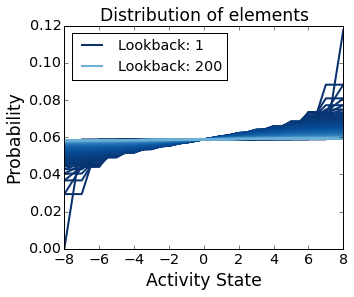

In [94]:
def clip_decay_plot(lb, clip=5):
    vec = np.ones(2*clip+1)
    
    vec[0] -= 1
    vec[-1] += 1
    
    decay = np.zeros(lb)
    cm = get_cmap('Blues_r', lb+200)
    len(vec)
    for l in range(lb):
        
        #print np.array_str(vec, precision=2)
        #if mod(l, 1) == 0:
        
        if l == 0 or l == (lb-1):
            plot(arange(-clip, clip+1), vec/ ((2*clip+1)), color=cm(l), lw=2, label='Lookback: %i' % (l+1))
        else:
            plot(arange(-clip, clip+1), vec/ ((2*clip+1)), color=cm(l), lw=2)
        
        decay[l] = np.sum(vec * arange(-clip, clip+1)) / ((2*clip+1))
        
        vect = vec.copy()
        
        vec[1:-1] = (vect[:-2] + vect[2:]) / 2
        
        vec[0] = (vect[0] + vect[1]) / 2
        vec[-1] = (vect[-1] + vect[-2]) / 2
        
        #plot(arange(-clip, clip+1), vec)
        
    return decay


clip=8
lookback = 200
figure(figsize=(5,4))
decay = clip_decay_plot(lookback, clip=clip)
title('Distribution of elements')
ylabel('Probability')
xlabel('Activity State')
legend(loc='upper left')

#yscale('log')

savefig('figures/capacity-clip-distribution' + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity-clip-distribution' + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

In [149]:
test_clip=[3, 4, 5, 6, 7]
lookback=4
for clip in test_clip:
    clip_decay_plot(lookback, clip=clip)
    print ''
    
    

[ 0.  1.  1.  1.  1.  1.  2.]
[ 0.5  0.5  1.   1.   1.   1.5  1.5]
[ 0.5   0.75  0.75  1.    1.25  1.25  1.5 ]
[ 0.62  0.62  0.88  1.    1.12  1.38  1.38]

[ 0.  1.  1.  1.  1.  1.  1.  1.  2.]
[ 0.5  0.5  1.   1.   1.   1.   1.   1.5  1.5]
[ 0.5   0.75  0.75  1.    1.    1.    1.25  1.25  1.5 ]
[ 0.62  0.62  0.88  0.88  1.    1.12  1.12  1.38  1.38]

[ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.]
[ 0.5  0.5  1.   1.   1.   1.   1.   1.   1.   1.5  1.5]
[ 0.5   0.75  0.75  1.    1.    1.    1.    1.    1.25  1.25  1.5 ]
[ 0.62  0.62  0.88  0.88  1.    1.    1.    1.12  1.12  1.38  1.38]

[ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.]
[ 0.5  0.5  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.5  1.5]
[ 0.5   0.75  0.75  1.    1.    1.    1.    1.    1.    1.    1.25  1.25
  1.5 ]
[ 0.62  0.62  0.88  0.88  1.    1.    1.    1.    1.    1.12  1.12  1.38
  1.38]

[ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.]
[ 0.5  0.5  1.   1.   1.   1.   1.   1.   1.   1.   1.   1. 

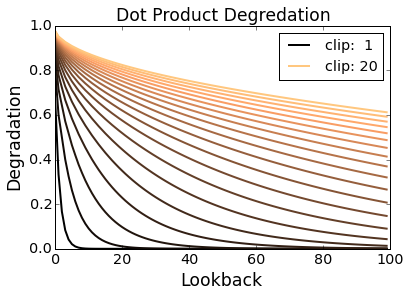

In [46]:
test_clip = arange(20)+1

cm = get_cmap('copper', len(test_clip))
for ic,clip in enumerate(test_clip):
    cdecay, cvar = clip_decay2(100, clip=clip)
    if ic >= 1 and ic < len(test_clip) - 1:
        plot(cdecay, color=cm(ic), lw=2)
    else:
        plot(cdecay, color=cm(ic), label='clip: %2i'%clip, lw=2)
    
legend()
ylabel('Degradation')
xlabel('Lookback')
title('Dot Product Degredation')

savefig('figures/capacity-clip-degredation' + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity-clip-degredation' + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

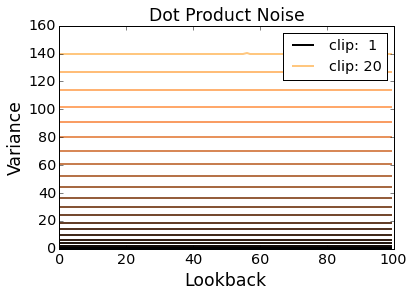

In [47]:
test_clip = arange(20)+1

cm = get_cmap('copper', len(test_clip))
for ic,clip in enumerate(test_clip):
    cdecay, cvar = clip_decay2(100, clip=clip)
    #cvar /= ((2*clip+1)**2-1)/12
    if ic >= 1 and ic < len(test_clip) - 1:
        plot(cvar, color=cm(ic), lw=2)
    else:
        plot(cvar, color=cm(ic), label='clip: %2i'%clip,lw=2)
    
legend()
ylabel('Variance')
xlabel('Lookback')
title('Dot Product Noise')

savefig('figures/capacity-clip-noise_var' + '-n' + time.strftime('%y%m%d') + '.png', format='png', transparent=True)
savefig('figures/capacity-clip-noise_var' + '-n' + time.strftime('%y%m%d') + '.eps', format='eps', transparent=True)

In [582]:
test_clip

array([ 1,  3,  5, 10, 20, 40, 80])

In [211]:
ll

0.006211180124223602

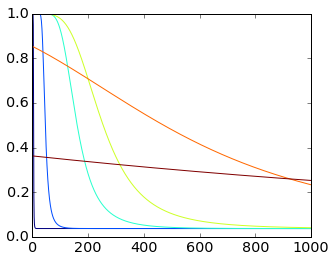

In [197]:
test_ll = [0.5, 0.95, 0.99, 0.995, 0.999, 0.99975]
M = arange(1000)
cm = get_cmap('jet', len(test_ll))

figure(figsize=(5,4))
for il,ll in enumerate(test_ll):
    plot(M, p_correct_decay(M, N=N, ll=ll), color=cm(il))

## Comparison to Eigenvalue

In [137]:
def test_capacity_decay_lookback(N, D, decay=1, trials=25e3):
    letter_vectors = 2 * (np.random.randn(D, N) > 0) - 1

    hypercapacity = np.zeros(N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    hypercapacity = letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)

    for i in range(int(trials)-1):
        
        lidx[i+1] = np.random.randint(D)

        hypercapacity = np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :]

        v_last_input = np.roll(hypercapacity, -1)
        #v_input_K = np.roll(hypercapacity, -K) # we can still do this less than K, it will just be noise
        v_first_input = np.roll(hypercapacity, -(i+1))
        
        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        #lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))
        
    # instead of keeping a single K, going to look back with increasing K at the end
    for i in range(int(trials)):
        v_input_K = np.roll(hypercapacity, -(int(trials)-i-1))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input, hypercapacity

In [139]:
test_N = [2000, 5000]
test_D = [8]

#test_N = [100, 300, 900, 2700, 8100, 24300]
runs = 5

run_id = []
run_N = []
run_D = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []



for r in range(runs):
    print r
    for N in test_N:
        decay=1-exp(1/2)*25/N
        for D in test_D:
            lidx, lidx_li, lidx_iK, lidx_fi, hypvec = test_capacity_decay_lookback(N, D, decay=decay)
        
            run_id.append(r)
            run_N.append(N)
            run_D.append(D)
            lidx_all.append(lidx)
            lidx_li_all.append(lidx_li)
            lidx_iK_all.append(lidx_iK)
            lidx_fi_all.append(lidx_fi)
        



0


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: Depre

Duration:  4.37567901611
Duration:  8.588296175
1
Duration:  4.02849411964
Duration:  7.43607401848
2
Duration:  4.25706005096
Duration:  7.20579600334
3
Duration:  3.75474715233
Duration:  7.59370684624
4
Duration:  3.74104499817
Duration:  8.28810191154


(array([    8.,    41.,   205.,   697.,  1300.,  1380.,   908.,   342.,
           98.,    21.]),
 array([-29.43611914, -23.80149058, -18.16686202, -12.53223345,
         -6.89760489,  -1.26297633,   4.37165224,  10.0062808 ,
         15.64090936,  21.27553792,  26.91016649]),
 <a list of 10 Patch objects>)

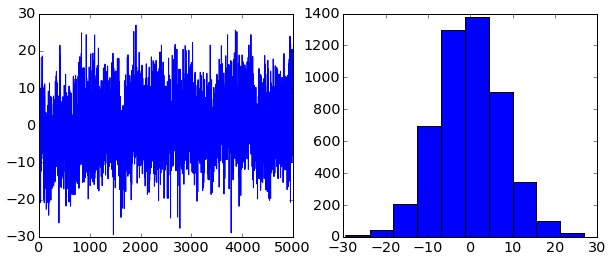

In [140]:
figure(figsize=(10,4))

subplot(121)
plot(hypvec)

subplot(122)
hist(hypvec)

In [423]:
test_clip = [1]
test_N = [1000, 2000, 4000]

test_means = np.zeros((len(test_clip), len(test_N)))
test_vars = np.zeros((len(test_clip), len(test_N)))

for ic,clip in enumerate(test_clip):
    for iN,N in enumerate(test_N):
        filled_hypvec = np.round((2*clip+1)*np.random.rand(N, 500) - clip - 0.5)
        lv = 2 * (np.random.randn(N) < 0) - 1

        res = np.dot(lv.T, filled_hypvec)
        
        test_means[ic, iN] = mean(res)
        test_vars[ic, iN] = var(res)
        

(array([ 1373.,     0.,     0.,     0.,     0.,  1338.,     0.,     0.,
            0.,  1289.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

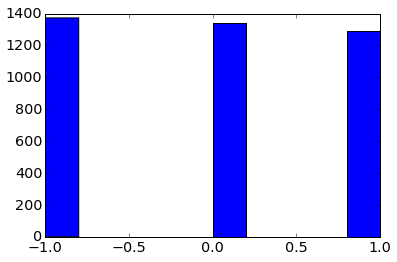

In [422]:
hist(filled_hypvec[:,1])

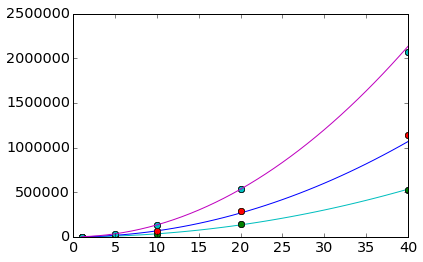

In [262]:

for iN in range(len(test_N)):
    plot(test_clip, test_vars, 'o')
    clipx = np.arange(1, max(test_clip)+1)
    plot(clipx, test_N[iN] * clipx ** 2 / 3)

In [502]:
test_clip = [1, 2, 3, 4, 5, 10, 20]
test_N = [4000]

samps = 1000
lookback = 500

testh_means = np.zeros((len(test_clip), len(test_N), lookback))
testh_vars = np.zeros((len(test_clip), len(test_N), lookback))


for ic,clip in enumerate(test_clip):
    tstart = time.time()
    
    for iN,N in enumerate(test_N):
        filled_hypvec = np.round((2*clip+1)*np.random.rand(N, samps) - clip - 0.5)
        lv = 2 * (np.random.randn(N) < 0) - 1
        
        filled_hypvec += tile(lv.T, (samps,1)).T
        
        filled_hypvec[filled_hypvec > clip] = clip
        filled_hypvec[filled_hypvec < -clip] = -clip
        
        for l in range(lookback):
            res = np.dot(lv.T, filled_hypvec)
        
            testh_means[ic, iN, l] = mean(res)
            testh_vars[ic, iN, l] = var(res)
            
            filled_hypvec += 2 * (np.random.randn(N, samps) < 0) - 1
            
            filled_hypvec[filled_hypvec > clip] = clip
            filled_hypvec[filled_hypvec < -clip] = -clip

    print clip, ' Duration: ', time.time() - tstart
        

1  Duration:  150.099540949
2  Duration:  148.328685999
3  Duration:  147.632040977
4  Duration:  148.280220032
5  Duration:  143.914530993
10  Duration:  141.117695093
20  Duration:  135.80488801


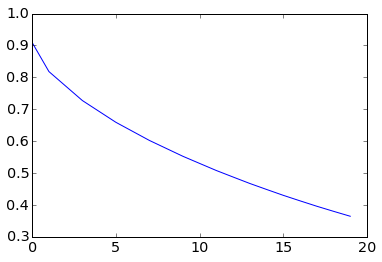

In [530]:
def clip_decay(lb, clip=5):
    vec = arange(-clip, clip+1)
    vec += 1
    
    decay = np.zeros(lb)
    
    for l in range(lb):
        vec[vec > clip] = clip
        vec[vec < -clip] = -clip
        
        decay[l] = vec.sum() / ((2*clip+1)*2**l)
        
        vecp = vec + 1
        vecn = vec - 1
        
        vec = vstack((vecp, vecn))
        
    return decay
plot(clip_decay(20))
        
        

(0, 10)

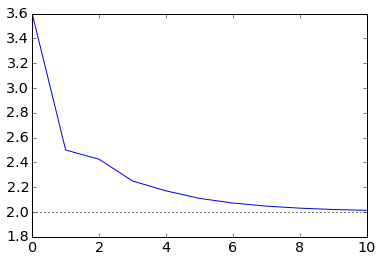

In [659]:
def clip_decay_var(lb, clip=5):
    vec = np.ones(2*clip+1)
    
    vec[0] -= 1
    vec[-1] += 1
    
    vdecay = np.zeros(lb)
    
    for l in range(lb):
        
        #print np.array_str(vec, precision=2)
        #if mod(l, 2) == 0:
        #    plot(arange(-clip, clip+1), vec)
        
        vdecay[l] = np.sum((vec * arange(-clip, clip+1))**2) / ((2*clip+1))
        
        vect = vec.copy()
        
        vec[1:-1] = (vect[:-2] + vect[2:]) / 2
        
        vec[0] = (vect[0] + vect[1]) / 2
        vec[-1] = (vect[-1] + vect[-2]) / 2
        
        #plot(arange(-clip, clip+1), vec)
        
    return vdecay


#plot(clip_decay(20))
#plot(clip_decay2(20))
     
clip = 2
plot(clip_decay_var(500, clip=clip))
plot([0, 500], [((2*clip+1)**2-1)/12, ((2*clip+1)**2-1)/12], ':k')        
xlim([0,10])

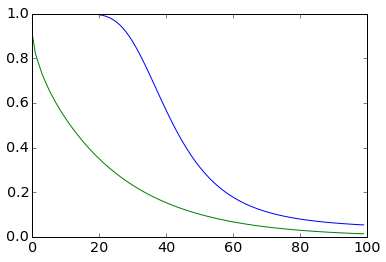

In [676]:
clip=5

plot(p_correct_clip(arange(100), N=2000, clip=clip))
plot(clip_decay2(100, clip=clip))

In [646]:
d = p_correct_clip(arange(10), N=2000, clip=2)

In [647]:
print d

[  8.94131383e-01   1.63447867e-05   6.95443703e-13   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


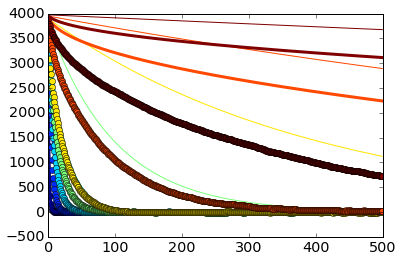

In [586]:
cm = get_cmap('jet', len(test_clip))

for ic in range(len(test_clip)):
    for iN in range(len(test_N)):
        plot(arange(lookback), testh_means[ic, iN, :], 'o', color=cm(ic))
        
        ll = 1 - 1/(test_clip[ic]**2 + 1)
        
        plot(arange(lookback), test_N[iN] * (1 - 1/(2*test_clip[ic]+1)) * ll ** arange(lookback), color=cm(ic))
        plot(arange(lookback), test_N[iN] * clip_decay2(lookback, test_clip[ic]),
             color=cm(ic), lw=3)
#xlim([0,20])

(0, 100)

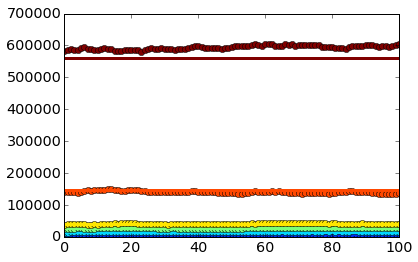

In [515]:
cm = get_cmap('jet', len(test_clip))

for ic in range(len(test_clip)):
    for iN in range(len(test_N)):
        plot(arange(lookback), testh_vars[ic, iN, :], 'o', color=cm(ic))
        plot(arange(lookback), np.ones(lookback)* test_N[iN] * (2*test_clip[ic]+1) ** 2 / 12, color=cm(ic), lw=3)
           
xlim([0,100])


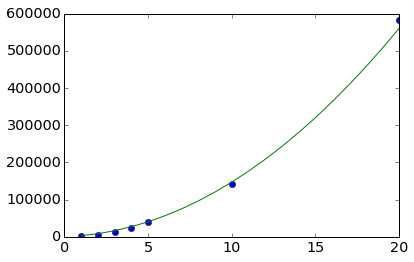

In [516]:

for iN in range(len(test_N)):
    plot(test_clip, testh_vars[:, iN, 0], 'o')
    clipx = np.arange(1, max(test_clip)+1)
    plot(clipx, test_N[iN] * (2*clipx+1) ** 2 / 12)
    


ValueError: x and y can be no greater than 2-D

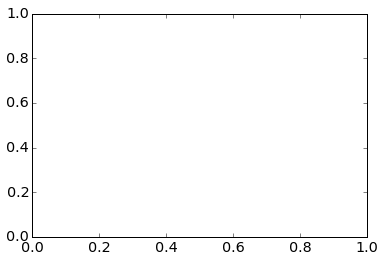

In [517]:

for iN in range(len(test_N)):
    plot(test_clip, testh_means, 'o')
    clipx = np.arange(1, max(test_clip)+1)
    #plot(clipx, test_N[iN] * (1 - 1/(clipx**2+1))**((lookback+1)))
    plot(clipx, test_N[iN]* (1 - 1.0/(2*clipx+1)) * (1-1.0/(clipx**2+1))** ((lookback)) )

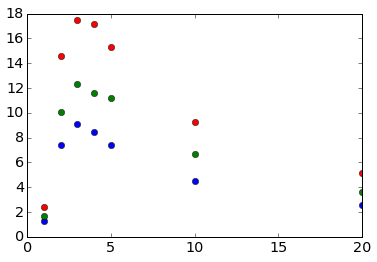

In [349]:

for iN in range(len(test_N)):
    plot(test_clip, testh_means[:, iN] / testh_vars[:, iN]**0.5, 'o')
    clipx = np.arange(1, max(test_clip)+1)
    #plot(clipx, test_N[iN] * (1 - 2/(2*clipx**2+1))**((lookback+1)))

In [256]:
print mean(noise_dist), var(noise_dist)

-2.55 676125.8875
